# Convolutional Neural Net Cancer Detection Mini-Project

Cancer is a prevalent issue in modern society. Between many common carcinogens found in our everyday lives and the average life expectancy increasing with each year, it becomes more and more important to accurately be able to detect cancer cells so that patients may recieve timely and adequate treatment. The goal of this project is to accurately predict whether or not an image contains cancerous cells. In order to accomplish this goal, we will create a series of convolutional neural nets with different levels of fine tuning to hopefully create an accurate model which is able to effectively identify cancer cells. 

In [88]:
#import libraries

import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator



In [89]:
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
final_df = pd.DataFrame({'id':os.listdir('../input/histopathologic-cancer-detection/test/')})
print(len(os.listdir('../input/histopathologic-cancer-detection/train/')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test/')))

220025
57458


The data itself is split into multiple parts, training and test data.
There are 220025 train data points and 57458 test data points. Each data point comes with a label of 0 or 1 making this a binary classification problem in which 0 is no cancer cells while 1 indicates some cancer cells. These labels are attached to an id which will let us connect them to their respective image. Each data point also contains a 96x96 image with RGB encoding, of which we are told that a positive or negative are only determined by the middle 32x32 pixels.

# Exploratory Data Analysis

### Null Values


In [90]:
#Checking for null values
df.isnull().sum()

id       0
label    0
dtype: int64

Since there are no null values and the values themselves are binary, there's nothing to be done here.

### Visualizing the data

<AxesSubplot:xlabel='label', ylabel='count'>

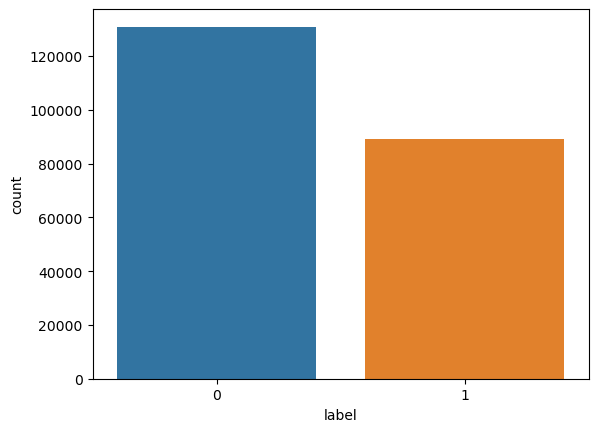

In [91]:
sns.countplot(data = df, x = 'label')

The data appears to be split relatively evenly between 1 and 0 or True and False for cancer with slightly more values of 0 (maybe 15-20% of the total). With that in mind it doesn't feel necessary to split the data again since, while it is slightly unbalanced, it is not horribly unbalanced such as an 80/20 split so we will continue using the whole dataset without fear that we may undertrain our model on one label.

### What the images actually look like

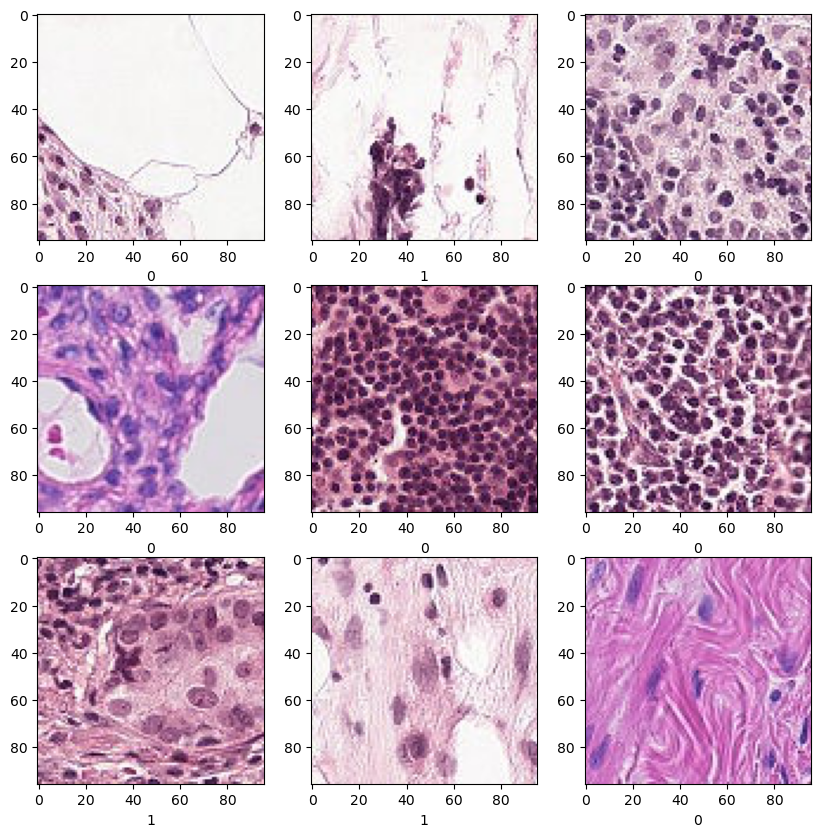

In [6]:
#Display the first 9 images of the training data set

fig, ax = plt.subplots(3,3, figsize = (10,10))

for i in range(9):
    ax = plt.subplot(3,3, i+1)
    path = '../input/histopathologic-cancer-detection/train/' + df.id[i] + '.tif'
    image = img.imread(path)
    ax.imshow(image)
    ax.set(xlabel = df.label[i])

Judging from the images itself, it seems relatively difficult to tell which images are cancerous and which are not to the untrained eye. Initially, we considered looking for black markers but those appear in images without cancer as well. 

The images themselves are 96x96 pixels with RGB channels but the points of interest for this competition are the middle 32x32 pixels. However, we will choose to leave the pixels as 96x96 since, by using multiple convolutional layers, we should be able to capture both the fine grain specifics as well as the more general features present in each image. 

As such the only preprocessing to be done will be to split the data into training and test data based on an 80/20 split and to normalize the pixel data to help model training.

In [ ]:
#Set train test split for model evaluation
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 0)

#Verify split
print(train_df.shape, test_df.shape)

#add .tif to ids and change labels to strings
train_df.id = train_df.id + '.tif'
test_df.id = test_df.id + '.tif'

train_df.label = train_df.label.astype(str)
test_df.label = test_df.label.astype(str)

In [10]:
#generate the train and test images and normalize using ImageDataGenerator

df_gen = ImageDataGenerator(rescale = 1/255)

train_gen = df_gen.flow_from_dataframe(dataframe = train_df,
                                      directory = '../input/histopathologic-cancer-detection/train/',
                                      x_col = 'id',
                                      y_col = 'label',
                                      batch_size = 64,
                                      seed = 0,
                                      class_mode = 'binary',
                                       target_size = (96,96)
                                      )
test_gen = df_gen.flow_from_dataframe(dataframe = test_df,
                                      directory = '../input/histopathologic-cancer-detection/train/',
                                      x_col = 'id',
                                      y_col = 'label',
                                      batch_size = 64,
                                      seed = 0,
                                      class_mode = 'binary',
                                       target_size = (96,96)
                                      )

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Model Architecture

We will be using Keras' base convolutional neural network for this model. We will create a base model which will have 5 convolutional layers each using relu as their activation function. Alongside these layers we will also include one instance of batch normalization and two pooling layers of size 2 each. Finally were will have an output layer using the sigmoid activation function since this is a binary classification problem.

For this problem we will also do hyperparameter tuning across dropout values and number of convolutional layers.

Both for both models the image data will be normalized and the two models will be trained over 10 epochs. The batch size for both models will be set to 64 since training with too large a batch size can lead to a loss of generalization.

Finally, the two models will be compared on validation accuracy and the better performing model will be submitted for this competition.

### Default CNN

In [36]:
#function to create CNN models
def create_model(optimizer = 'adam', dropout_rate = 0.2, n_conv_layers = 3):
    n = n_conv_layers
    model = Sequential()
    
    #add initial layer
    model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu', input_shape = (96,96,3)))
    model.add(BatchNormalization())          
    #add number of conv layers and pooling layers
    for i in range(n-2):
        model.add(Conv2D(16*(2**i+1), kernel_size = (3,3), activation = 'relu'))
        model.add(Conv2D(16*(2**i+1), kernel_size = (3,3), activation = 'relu'))
        model.add(AveragePooling2D(pool_size = (2,2)))
        if dropout_rate !=0:
                  model.add(Dropout(rate = dropout_rate))
                  
    #add final dense layer
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model 
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model             

In [37]:
#Create a base model using the ADAM optimizer, a dropout rate of 0, and 3 convolutional layers.
cnn = create_model(optimizer = 'adam', dropout_rate = 0, n_conv_layers = 3)
cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 batch_normalization_7 (Batc  (None, 94, 94, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_26 (Conv2D)          (None, 92, 92, 32)        4640      
                                                                 
 conv2d_27 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 average_pooling2d_10 (Avera  (None, 45, 45, 32)       0         
 gePooling2D)                                                    
                                                                 
 flatten_7 (Flatten)         (None, 64800)            

In [38]:
#Fit the model to the training data and evaluate it on the validation data
cnn_base = cnn.fit_generator(generator = train_gen,
                            epochs = 10,
                            workers = 8,
                            validation_data = test_gen
                            )

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


2751/2751 [==============================] - 266s 96ms/step - loss: 0.3886 - accuracy: 0.8342 - val_loss: 0.4118 - val_accuracy: 0.8173
Epoch 2/10
2751/2751 [==============================] - 265s 96ms/step - loss: 0.3474 - accuracy: 0.8561 - val_loss: 0.3453 - val_accuracy: 0.8616
Epoch 3/10
2751/2751 [==============================] - 267s 97ms/step - loss: 0.3142 - accuracy: 0.8712 - val_loss: 0.3811 - val_accuracy: 0.8515
Epoch 4/10
2751/2751 [==============================] - 266s 96ms/step - loss: 0.2730 - accuracy: 0.8896 - val_loss: 0.3462 - val_accuracy: 0.8577
Epoch 5/10
2751/2751 [==============================] - 264s 96ms/step - loss: 0.2346 - accuracy: 0.9067 - val_loss: 0.3542 - val_accuracy: 0.8630
Epoch 6/10
2751/2751 [==============================] - 267s 97ms/step - loss: 0.2047 - accuracy: 0.9185 - val_loss: 0.4146 - val_accuracy: 0.8425
Epoch 7/10
2751/2751 [==============================] - 267s 97ms/step - loss: 0.1794 - accuracy: 0.9305 - val_loss: 0.3704 - val

### Tuned Models

Next we will create two additional models to tune the hyperparameters for dropout rate and the number of convolutional layers. The second model will use a dropout rate of 0.2 and 3 convolutional layers while the third model will use a dropout rate of 0.2 and 5 convolutional layers.

In [40]:
#Create a tuned model with a dropout rate of 0.2 and 3 convolutional layers
cnn_2 = create_model(optimizer = 'adam', dropout_rate = 0.2, n_conv_layers = 3)
cnn_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 batch_normalization_8 (Batc  (None, 94, 94, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_29 (Conv2D)          (None, 92, 92, 32)        4640      
                                                                 
 conv2d_30 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 average_pooling2d_11 (Avera  (None, 45, 45, 32)       0         
 gePooling2D)                                                    
                                                                 
 dropout_6 (Dropout)         (None, 45, 45, 32)       

In [45]:
#Fit the model to the training data and evaluate it on the validation data
cnn_2_tuning = cnn_2.fit_generator(generator = train_gen,
                            epochs = 10,
                            workers = 8,
                            validation_data = test_gen
                            )

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


2751/2751 [==============================] - 266s 96ms/step - loss: 0.3907 - accuracy: 0.8334 - val_loss: 0.4047 - val_accuracy: 0.8435
Epoch 2/10
2751/2751 [==============================] - 284s 103ms/step - loss: 0.3434 - accuracy: 0.8574 - val_loss: 0.3856 - val_accuracy: 0.8480
Epoch 3/10
2751/2751 [==============================] - 274s 100ms/step - loss: 0.3132 - accuracy: 0.8709 - val_loss: 0.3977 - val_accuracy: 0.8301
Epoch 4/10
2751/2751 [==============================] - 265s 96ms/step - loss: 0.2832 - accuracy: 0.8841 - val_loss: 0.3030 - val_accuracy: 0.8727
Epoch 5/10
2751/2751 [==============================] - 264s 96ms/step - loss: 0.2579 - accuracy: 0.8953 - val_loss: 0.6259 - val_accuracy: 0.7608
Epoch 6/10
2751/2751 [==============================] - 301s 109ms/step - loss: 0.2324 - accuracy: 0.9068 - val_loss: 0.3357 - val_accuracy: 0.8607
Epoch 7/10
2751/2751 [==============================] - 266s 97ms/step - loss: 0.2154 - accuracy: 0.9134 - val_loss: 0.4034 - 

In [41]:
#Create a tuned model with a dropout rate of 0.2 and 3 convolutional layers
cnn_3 = create_model(optimizer = 'adam', dropout_rate = 0.2, n_conv_layers = 5)
cnn_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 batch_normalization_9 (Batc  (None, 94, 94, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_32 (Conv2D)          (None, 92, 92, 32)        4640      
                                                                 
 conv2d_33 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 average_pooling2d_12 (Avera  (None, 45, 45, 32)       0         
 gePooling2D)                                                    
                                                                 
 dropout_7 (Dropout)         (None, 45, 45, 32)       

In [46]:
#Fit the model to the training data and evaluate it on the validation data
cnn_3_tuning = cnn_3.fit_generator(generator = train_gen,
                            epochs = 10,
                            workers = 8,
                            validation_data = test_gen
                            )

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


2751/2751 [==============================] - 277s 100ms/step - loss: 0.3817 - accuracy: 0.8338 - val_loss: 0.3948 - val_accuracy: 0.8337
Epoch 2/10
2751/2751 [==============================] - 274s 99ms/step - loss: 0.2975 - accuracy: 0.8755 - val_loss: 0.2615 - val_accuracy: 0.8928
Epoch 3/10
2751/2751 [==============================] - 272s 99ms/step - loss: 0.2555 - accuracy: 0.8970 - val_loss: 0.2252 - val_accuracy: 0.9088
Epoch 4/10
2751/2751 [==============================] - 286s 104ms/step - loss: 0.2323 - accuracy: 0.9088 - val_loss: 0.2465 - val_accuracy: 0.9058
Epoch 5/10
2751/2751 [==============================] - 268s 97ms/step - loss: 0.2142 - accuracy: 0.9164 - val_loss: 0.2195 - val_accuracy: 0.9116
Epoch 6/10
2751/2751 [==============================] - 269s 98ms/step - loss: 0.2022 - accuracy: 0.9220 - val_loss: 0.2053 - val_accuracy: 0.9194
Epoch 7/10
2751/2751 [==============================] - 270s 98ms/step - loss: 0.1935 - accuracy: 0.9258 - val_loss: 0.2198 - v

## Results and Analysis

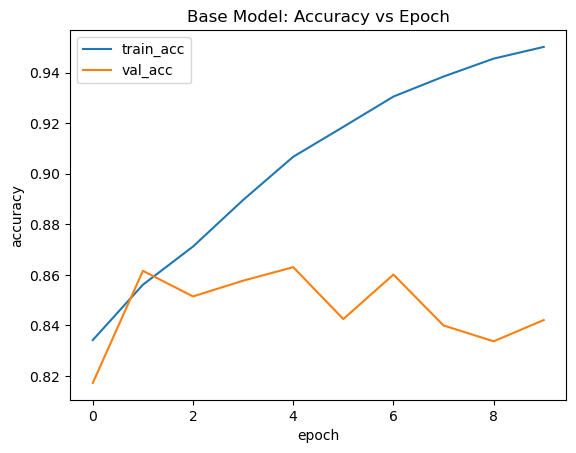

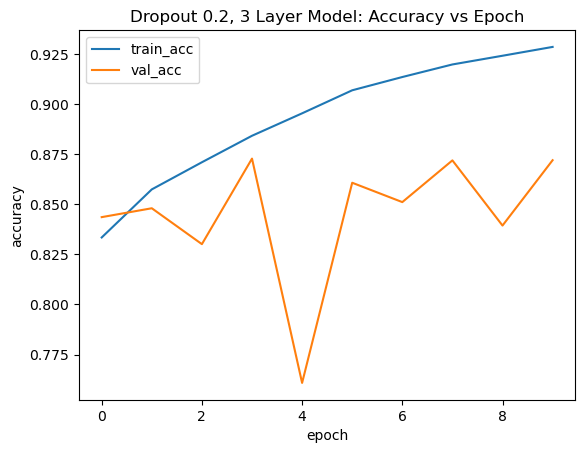

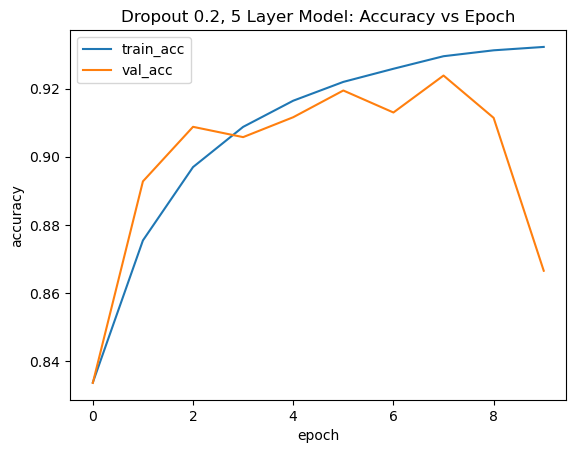

In [47]:
plt.plot(cnn_base.history['accuracy'], label = 'train_acc')
plt.plot(cnn_base.history['val_accuracy'], label = 'val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Base Model: Accuracy vs Epoch')
plt.show()

plt.plot(cnn_2_tuning.history['accuracy'], label = 'train_acc')
plt.plot(cnn_2_tuning.history['val_accuracy'], label = 'val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Dropout 0.2, 3 Layer Model: Accuracy vs Epoch')
plt.show()

plt.plot(cnn_3_tuning.history['accuracy'], label = 'train_acc')
plt.plot(cnn_3_tuning.history['val_accuracy'], label = 'val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Dropout 0.2, 5 Layer Model: Accuracy vs Epoch')
plt.show()

Of the three models created, the model with dropout of 0.2 and 5 convolutional layers performed the best with a max validation accuracy of 0.9238. 

It is not surprising that adding some level of dropout and increasing the number of convolutional layers increased the validation accuracy of the models, increases the dropout provides an extra source of regularization besides the one instance of batch normalization present in each model. Adding more convolutional layers allows the model to have a better field of view of the images which should naturally increase the models accuracy.

From these graphs we can also tell that the validation accuracy never converged. This could be due to having too low of a learning rate but it's more likely that this is due to having a low number of epochs due to the computational cost.

In [53]:
#need to normalize and prepare the test data so that the model can interpret it
final_tester = ImageDataGenerator(1/255)
final_gen = final_tester.flow_from_dataframe(dataframe = final_df,
                                      directory = '../input/histopathologic-cancer-detection/test/',
                                      x_col = 'id',
                                      batch_size = 64,
                                      seed = 0,
                                      target_size = (96,96),
                                      class_mode = None)

Found 57458 validated image filenames.


In [54]:
pred = cnn_3.predict(final_gen).T[0]
pred

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


898/898 [==============================] - 526s 586ms/step


array([0.01093745, 0.        , 0.01093745, ..., 0.01093745, 0.01093745,
       0.01093745], dtype=float32)

In [83]:
submission = pd.DataFrame()
submission['id'] = final_df['id']
submission['label'] = pred
submission.label = np.where(submission.label < 0.5, 0, 1)
submission.label.value_counts()

0    49874
1     7584
Name: label, dtype: int64

In [87]:
submission.to_csv('submission.csv', index = False)

## Conclusion

In this mini-project, we found that adding some level of dropout and increasing the number of convolutional layers helped improve the accuracy of our model. However, we did find a larger increase in accuracy from increasing the number of convolutional layers rather than adding dropout. This is likely due to the fact that each model already included some level of regularization in the batch normalization layer.

There are a number of ways our final model could be improved. First, we could have adjusted the images so the models were trained soley on the middle 32x32 pixels. Since those pixels are the only pixels which have an effect on whether an image is classified as having cancer or not it would help to remove some of the overall noise of the model by allowing to to focus only on the parts of the images that actually matter. Secondly, there were a number of hyperparameters that we did not tune including but not limited to: optimizer, strides, activation function of the convolutional layers, and learning rate. Additionally, we could've done further tuning on the dropout rate as well as the number of convolutional layers. The reason these were excluded from this project was due to computational time, each model fitting took on average roughly 50 minutes while using the GPU. Ideally, given more computational power and time, it would make sense to use something like a GridSearch to finds the optimal parameters for all the hyperparameters so that we end up with the model with the highest possible validation accuracy. Unfortunately on this current setup that would have taken roughly 50 hours of runtime which is not feasible for a mini-project.